<a href="https://colab.research.google.com/github/AurelienLELEU/task1/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

Web Scrapping


In [ ]:
import requests
from bs4 import BeautifulSoup
import time

all_reviews = []
page = 1

while True:
    url = f"https://fr.trustpilot.com/review/www.apple.fr?page={page}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)

    # Si il n'y a plus de page, on arrête le scraping
    if response.status_code != 200:
        print(f"Erreur lors de la récupération de la page {page}. Fin du scraping.")
        break

    soup = BeautifulSoup(response.text, 'html.parser')

    # Extraction des reviews en utilisant la balise et la classe fournie
    for tag in soup.find_all('p', class_='typography_body-l__v5JLj typography_appearance-default__t8iAq'):
        # Si le <p> contient un <span class="styles_previewText__afbaG">, on ignore (continue)
        if tag.find('span', class_='styles_previewText__afbaG'):
            continue

        # Sinon, on récupère le texte complet
        review = tag.get_text(strip=True)

        if review == 'France' or review == 'Total :1 300':
            continue

        all_reviews.append(review)

    page += 1
    time.sleep(1)  # Pause pour respecter le serveur

print("Nombre total d'avis extraits :", len(all_reviews))

Erreur lors de la récupération de la page 64. Fin du scraping.
Nombre total d'avis extraits : 1208


Import dans un CSV

In [ ]:
import csv
# Écriture de toutes les reviews dans un CSV brut
with open('reviews.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    for review in all_reviews:
        writer.writerow([review])
print("Fichier 'reviews.csv' créé avec toutes les reviews.")

Fichier 'reviews.csv' créé avec toutes les reviews.


## BERT

In [ ]:
%pip install --upgrade sentencepiece transformers tensorflow tf-keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 965.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
  Attempti

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/272M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Fichier 'reviews_with_sentiment.csv' créé avec la classification de sentiment.


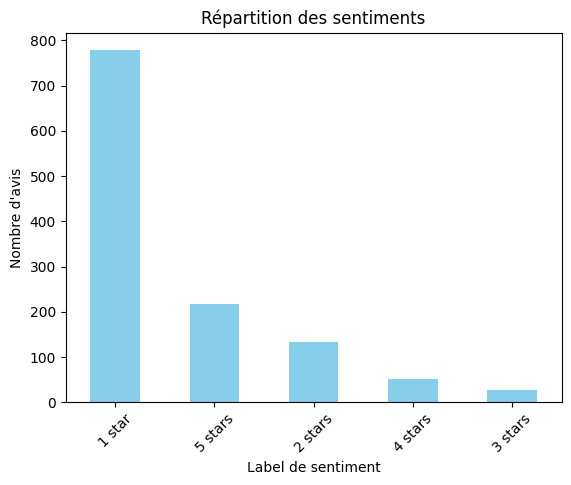

In [ ]:
import json
from transformers import pipeline, AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd

#Fichiers d'entrée et de sortie
csv_input = 'reviews.csv'
csv_output = 'reviews_with_sentiment.csv'

#Charger les avis
df = pd.read_csv(csv_input, header=None, names=["review"])

#Charger le modèle DistilCamemBERT
model_name = "cmarkea/distilcamembert-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
analyzer = pipeline("text-classification", model=model_name, tokenizer=tokenizer)

#Analyser les sentiments
def analyze_sentiment(text):
    text = text[:512]  # Tronquer pour éviter les dépassements
    result = analyzer(text, return_all_scores=True)[0]
    best = max(result, key=lambda x: x['score'])
    return best['label'], best['score'], json.dumps(result, ensure_ascii=False)

df[["best_label", "best_score", "all_scores"]] = df["review"].apply(lambda x: pd.Series(analyze_sentiment(x)))

#Sauvegarder les résultats
df.to_csv(csv_output, index=False)
print(f"Fichier '{csv_output}' créé avec la classification de sentiment.")

#Statistiques et visualisation
count_labels = df["best_label"].value_counts()
count_labels.plot(kind='bar', color='skyblue', title="Répartition des sentiments")
plt.xlabel("Label de sentiment")
plt.ylabel("Nombre d'avis")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calcul du nombre total d'avis
total_reviews = len(df)

print("Résumé des sentiments des clients :")
print(f"Nombre total d'avis : {total_reviews}")

# Affichage du compte et du pourcentage pour chaque label
for label, count in count_labels.items():
    percentage = (count / total_reviews) * 100
    print(f"{label}: {count} avis ({percentage:.2f}%)")

Résumé des sentiments des clients :
Nombre total d'avis : 1208
1 star: 778 avis (64.40%)
5 stars: 218 avis (18.05%)
2 stars: 133 avis (11.01%)
4 stars: 52 avis (4.30%)
3 stars: 27 avis (2.24%)
